In [73]:
%matplotlib inline


# standard library
import os
import pytz
import json
import math
import codecs
import pandas
import operator
import datetime
import matplotlib
import dateutil.parser

from importlib import reload
from operator import itemgetter
from collections import Counter, defaultdict

# external libraries
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook


# our code
from cities2code import cities2code
import lib_untappd; reload(lib_untappd)
from lib_untappd import load_city_checkins, load_beers, list_collection_cities, load_users, load_venues, load_breweries


# define some things
norm = mpl.colors.Normalize(vmin=0, vmax=6)

DATA_DIR = "/Users/martin/Dropbox/Coding/tap/cache/data"
CHECKINS_DIR = os.path.join(DATA_DIR, 'checkins')

# don't actually use this now - we don't want to 
# read all the files as it contains data
# from the shorter monitoring period
city_files = [c for c in os.listdir(CHECKINS_DIR) if c.endswith('.json')]
city_names = [city[9:len(city)-5] for city in city_files]


# timezones for each city
city2timezone = json.load(open('dat_misc/timezones.json'))


# helper to convert datetime to local time
def dt_to_city_local(dt, city_name):
    """
    Convert json date `dt` to local time of city `city_name`.
    """
    dt = dt.replace(tzinfo=pytz.utc)
    zone = city2timezone[city_name]
    local_tz = pytz.timezone(zone)
    dt = dt.astimezone(local_tz)
    return dt

# turn date strings into native datetime objects
def as_datetime(date_str):
    # Sun, 12 May 2013 20:50:23 +0000
    date_str = date_str.split(', ')[1]
    date_str, offset = date_str.split(' +')
    assert offset == "0000"
    dt = datetime.datetime.strptime(date_str, '%d %b %Y %H:%M:%S')
    return dt

# set any matplotlib defaults
matplotlib.rcdefaults()
# matplotlib.rcParams['ps.useafm'] = True
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.grid'] = True

# cities still being considered post ICWSM paper
US_CITIES = [
    'newyork', 'losangeles', 'chicago', 'seattle', 'denver', 'boston', 'portland'
]
EU_CITIES = [
    'london', 'dublin','barcelona','paris','amsterdam','copenhagen'
]
CITIES =  US_CITIES + EU_CITIES


In [135]:
%%time

print(CITIES)

checkin_data = {}
for city in tqdm_notebook(CITIES):
    
    fp = os.path.join(CHECKINS_DIR, 'checkins_%s.json' % city)
    checkins = {}
    with open(fp, 'r') as f:
        for ln in tqdm_notebook(f.readlines()):
            c = json.loads(ln)
            rating = float(c['rating_score'])
            checkins[c['checkin_id']] = {
                'beer': c['beer'],
                'venue': c['venue'],
                'user': c['user'],
                'brewery': c['brewery'],
                'created_at': as_datetime(c['created_at']),
                'rating': rating
            }
    checkin_data[city] = checkins.values()

['newyork', 'losangeles', 'chicago', 'seattle', 'denver', 'boston', 'portland', 'london', 'dublin', 'barcelona', 'paris', 'amsterdam', 'copenhagen']


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


CPU times: user 12min 46s, sys: 1min 38s, total: 14min 24s
Wall time: 15min 55s


In [10]:
%%time

bid2brewery = load_breweries()
bid2beer = load_beers()
vid2venue = load_venues()
uid2user = load_users()

CPU times: user 59.8 s, sys: 3min 26s, total: 4min 26s
Wall time: 5min 13s


In [11]:
%%time

start_date = datetime.datetime.max
end_date = datetime.datetime.min

for city in CITIES:
    checkins = checkin_data[city]
    for c in checkins:
        if c['created_at'] < start_date:
            start_date = c['created_at']
        if c['created_at'] > end_date:
            end_date = c['created_at']
            
print(start_date)
print(end_date)

2015-08-13 00:00:02
2017-10-02 10:57:50


In [12]:
OBSERVATION_DAYS = (end_date - start_date).total_seconds() / (60*60*24)
print(OBSERVATION_DAYS)

781.4568055555555


In [14]:
checkin_count = {}
for city, checkins in checkin_data.items():
    checkin_count[city] = len(checkins)
    
print(checkin_count)

{'copenhagen': 692324, 'boston': 2217508, 'london': 1875637, 'seattle': 1822760, 'amsterdam': 1646201, 'newyork': 3286639, 'paris': 207386, 'barcelona': 266232, 'chicago': 3463391, 'denver': 1914426, 'portland': 1895871, 'losangeles': 1333866, 'dublin': 248436}


In [15]:
us_sum = sum([checkin_count[c] for c in US_CITIES])
eu_sum = sum([checkin_count[c] for c in EU_CITIES])
total = sum(checkin_count.values())

print("US Checkins: ", us_sum)
print("EU Checkins: ", eu_sum)
print("Total Checkins: ", total)

US Checkins:  15934461
EU Checkins:  4936216
Total Checkins:  20870677
20870677


In [16]:
print("Users: ", len(uid2user.keys()))
print("Beers: ", len(bid2beer.keys()))
print("Venues: ", len(vid2venue.keys()))
print("Breweries: ", len(bid2brewery.keys()))

Users:  893971
Beers:  414305
Venues:  848852
Breweries:  30931


In [17]:
%%time 

stats_headers = ['checkins', 'users', 'beers', 'venues', 'breweries', 'days']

stats = pandas.DataFrame(index=CITIES, columns=stats_headers)

for city, checkins in checkin_data.items():
    user_ids = set(c['user'] for c in checkins)
    venue_ids = set(c['venue'] for c in checkins if c.get('venue'))
    beer_ids = set(c['beer'] for c in checkins)
    brewery_ids = set(c['brewery'] for c in checkins)
    checkin_times = [c['created_at'] for c in checkins]
    tdelta = max(checkin_times) - min(checkin_times)
    days = tdelta.total_seconds()/(60.0 * 60 * 24.0)
    
    stats['checkins'].loc[city] = len(checkins)
    stats['users'].loc[city] = len(user_ids)
    stats['venues'].loc[city] = len(venue_ids)
    stats['beers'].loc[city] = len(beer_ids)
    stats['breweries'].loc[city] = len(brewery_ids)
    stats['days'].loc[city] = days

CPU times: user 1min 1s, sys: 35.5 s, total: 1min 36s
Wall time: 1min 48s


In [22]:
print(stats)

           checkins   users  beers venues breweries     days
newyork     3286639  157637  67181  72063      7531  781.448
losangeles  1333866   84579  45322  38903      4982  781.448
chicago     3463391  158148  64968  64376      6463  781.347
seattle     1822760   78480  52046  27400      5158   781.41
denver      1914426  103288  58412  30528      5019  781.314
boston      2217508  106706  47011  41152      5052  781.403
portland    1895871   66049  52278  24675      4978  781.406
london      1875637   84883  53643  39631      8286   780.71
dublin       248436   27202   8307   5970      2210  780.741
barcelona    266232   20466  15059  12845      2815  780.776
paris        207386   24088  15372  16508      3339   780.74
amsterdam   1646201   81757  37645  63029      6840  780.708
copenhagen   692324   32058  32911  18018      4290  780.717


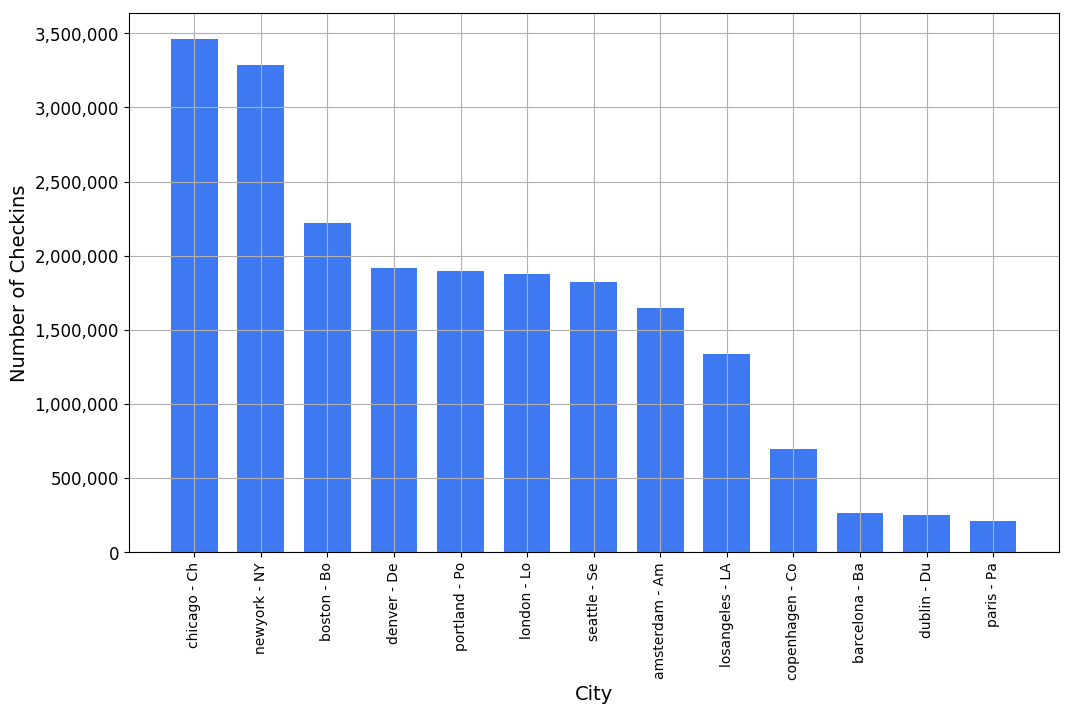

In [19]:
checkins_sorted = stats.sort_values(by='checkins', ascending=False)

fig = plt.figure(figsize=(12, 7))

fig.patch.set_facecolor('white')
ax = plt.gca()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(list(range(len(checkins_sorted.index.values))), 
        checkins_sorted['checkins'], width=0.7, alpha=1, color='#3f79f2', align='center')
plt.xticks(list(range(len(checkins_sorted.index.values))), 
        ['%s - %s' % (c, cities2code[c]) for c in checkins_sorted.index.values], rotation='vertical', fontsize=10)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
plt.ylabel('Number of Checkins', fontsize=14)
plt.xlabel('City', fontsize=14)
plt.autoscale()
plt.show()

fig.savefig('plots/checkins_per_city.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/checkins_per_city.png', bbox_inches='tight', pad_inches=0.5)

In [20]:
sorted_city_names = checkins_sorted.index.values

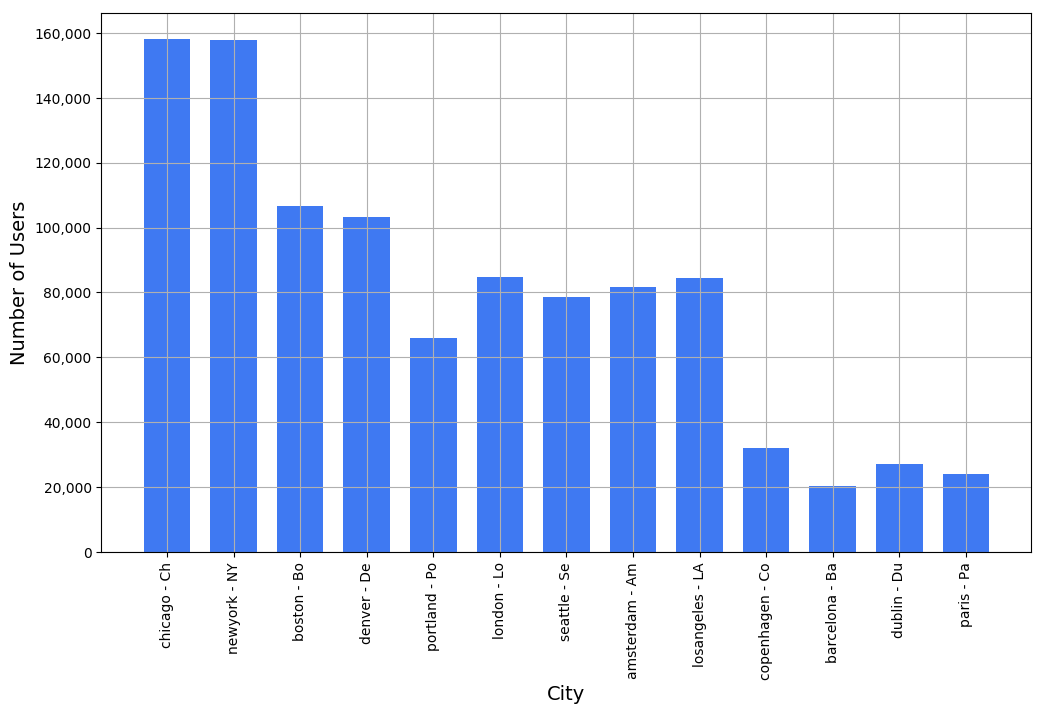

In [21]:
fig = plt.figure(figsize=(12, 7))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=10)
ax = plt.gca()
plt.bar(list(range(len(stats['users']))), checkins_sorted['users'], width=0.7, alpha=1, color='#3f79f2', align='center')
plt.xticks(list(range(len(checkins_sorted.index.values))), ['%s - %s' % (c, cities2code[c]) for c in checkins_sorted.index.values], rotation='vertical')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
plt.ylabel('Number of Users', fontsize=14)
plt.xlabel('City', fontsize=14)
plt.autoscale()
plt.show()

fig.savefig('plots/users_per_city.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/users_per_city.png', bbox_inches='tight', pad_inches=0.5)

In [24]:
def weekday(t):
    if t.hour < 5:
        return 6 if t.weekday() == 0 else t.weekday()-1
    else:
        return t.weekday()
    
def hour(t):
    if t.hour >= 5:
        return t.hour - 5
    else:
        return 19 + t.hour

In [25]:
days=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times = ['5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12am','1am','2am','3am','4am']

In [26]:
city_hourly_data = {}
for city in tqdm_notebook(CITIES):

    city_d = checkin_data[city]

    hourly_data = []
    for i in range(0,7):
        hourly_data.append([0]*24)

    hours_seen = []
    for i in range(0, 7):
        hours_seen.append([0]*24)

    dates = []

    for c in tqdm_notebook(city_d):
        dt = dt_to_city_local(c['created_at'], city)
        hourly_data[weekday(dt)][hour(dt)] += 1
        t_t = (dt.year, dt.month, dt.day, dt.hour)
        if t_t not in dates:
            hours_seen[weekday(dt)][hour(dt)] += 1
            dates.append(t_t)

    hd = pandas.DataFrame(hourly_data, index=days, columns=times)
    hs = pandas.DataFrame(hours_seen, index=days, columns=times)
    hd = hd.div(hs).T
    
    city_hourly_data[city] = hd


A Jupyter Widget

A Jupyter Widget

2602178/|/ 79%|| 2602178/3286639 [17:25<04:34, 2489.90it/s]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [28]:
for city in tqdm_notebook(CITIES):
    city_hourly_data[city].to_csv('data/%s_hourly_data.csv' % city)

A Jupyter Widget

In [30]:
for city in tqdm_notebook(CITIES):
    city_hourly_data[city] = pandas.read_csv('data/%s_hourly_data.csv' % city)

A Jupyter Widget

In [31]:
for city in tqdm_notebook(CITIES):

    cmap = cm.get_cmap('coolwarm')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig = plt.figure(figsize=(7, 4), dpi=300)

    fig.patch.set_facecolor('white')
    plt.tick_params(axis='both', which='major', labelsize=12)

    for i, day in enumerate(days):
        cp = m.to_rgba(i)
        plt.plot(city_hourly_data[city][day], c=(cp[0], cp[1], cp[2]), alpha=cp[3], lw=2, label=day)

    plt.xticks(range(24), times, rotation='vertical')

    plt.ylabel('Average Number of Checkins', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.autoscale()

    fig.savefig('plots/checkins_per_hour_per_day_%s.pdf' % (city), bbox_inches='tight', pad_inches=0.5)
    fig.savefig('plots/checkins_per_hour_per_day_%s.png' % (city), bbox_inches='tight', pad_inches=0.5)

    plt.close(fig)

A Jupyter Widget

In [32]:
# dictionary lookup for beer_id -> brewery_id
beer2brewery = {}

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        beer2brewery[c['beer']] = c['brewery']

# dictionary lookup for city -> list of users, num checkins by user in city
city2users = defaultdict(Counter)
# dictionary lookup for user -> list of beers, number of each beer drunk
user2beers = defaultdict(Counter)
# dictionary lookup for city -> list of beers, number of each beer drunk
city2beers = defaultdict(Counter)


for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        city2users[city][str(c['user'])] += 1
        user2beers[str(c['user'])][str(c['beer'])] += 1
        city2beers[city][c['beer']] += 1

A Jupyter Widget

A Jupyter Widget

In [34]:
global_unique_beer_count = Counter()
eu_unique_beer_count = Counter()
us_unique_beer_count = Counter()

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        if city in EU_CITIES:
            eu_unique_beer_count[c['beer']] += 1 
        elif city in US_CITIES:
            us_unique_beer_count[c['beer']] += 1
        global_unique_beer_count[c['beer']] += 1



A Jupyter Widget

In [46]:
def load_taxonomy():
    fpath='./dat_taxonomy/beeradv_with_UT_v2.txt'
    lines = codecs.open(fpath, 'r', 'utf-8').read().split('\n')
    lines = filter(lambda x: x != '', lines)

    tag2styles = {}
    style2tier1 = {}  # top level; e.g., 'ale', 'lager', etc.
    style2tier2 = {}  # fully qualifier level 2; e.g., 'ale-Belgian/FrenchAles'
    style2tier3 = {}  # fully qualifier level 3 / the leaf; e.g., 'ale-Belgian/FrenchAles:Belgian Brown Ale'

    for line in lines:
        if line.startswith('='):
            tag = line.replace('=', '')
            assert '-' in tag
            tag = tag.replace('-', ':')
            tag2styles[tag] = []
        else:
            tag2styles[tag].append(line)
            
            # validate hierarchy
            if line in style2tier2:
                assert style2tier2[line] == tag
                
            # save lookup into hierarchy
            style2tier1[line] = tag.split(':')[0]
            style2tier2[line] = tag
            leaf = line.strip()
            style2tier3[line] = "%s:%s" % (tag, line)
    assert set(style2tier1.keys()) == set(style2tier2.keys())
    return tag2styles, style2tier1, style2tier2, style2tier3

_, beerstyle2tier1, beerstyle2tier2, beerstyle2tier3  = load_taxonomy()

In [39]:
beer_abvs = defaultdict(list)

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        beer = bid2beer[c['beer']]
        beer_abvs[city].append(beer['beer_abv'])

A Jupyter Widget

In [51]:
global_beer_style_counts = Counter()

missing = set()

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        beer = bid2beer[c['beer']]
        b_style = beer['beer_style'].strip()
        if beerstyle2tier2.get(b_style):
            beer_style = beerstyle2tier2[b_style]
            global_beer_style_counts[beer_style] += 1
        else:
            missing.add(b_style)
            
print(missing)

A Jupyter Widget


set()


In [54]:
beer_style_counts = defaultdict(Counter)

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
        
    for style in global_beer_style_counts.keys():
        beer_style_counts[city][style] = 0
    for c in checkins:
        beer = bid2beer[c['beer']]
        b_style = beer['beer_style'].strip()
        beer_style = beerstyle2tier2[b_style]
        beer_style_counts[city][beer_style] += 1

A Jupyter Widget

In [55]:
city2beers = defaultdict(Counter)

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        city2beers[city][c['beer']] += 1

A Jupyter Widget

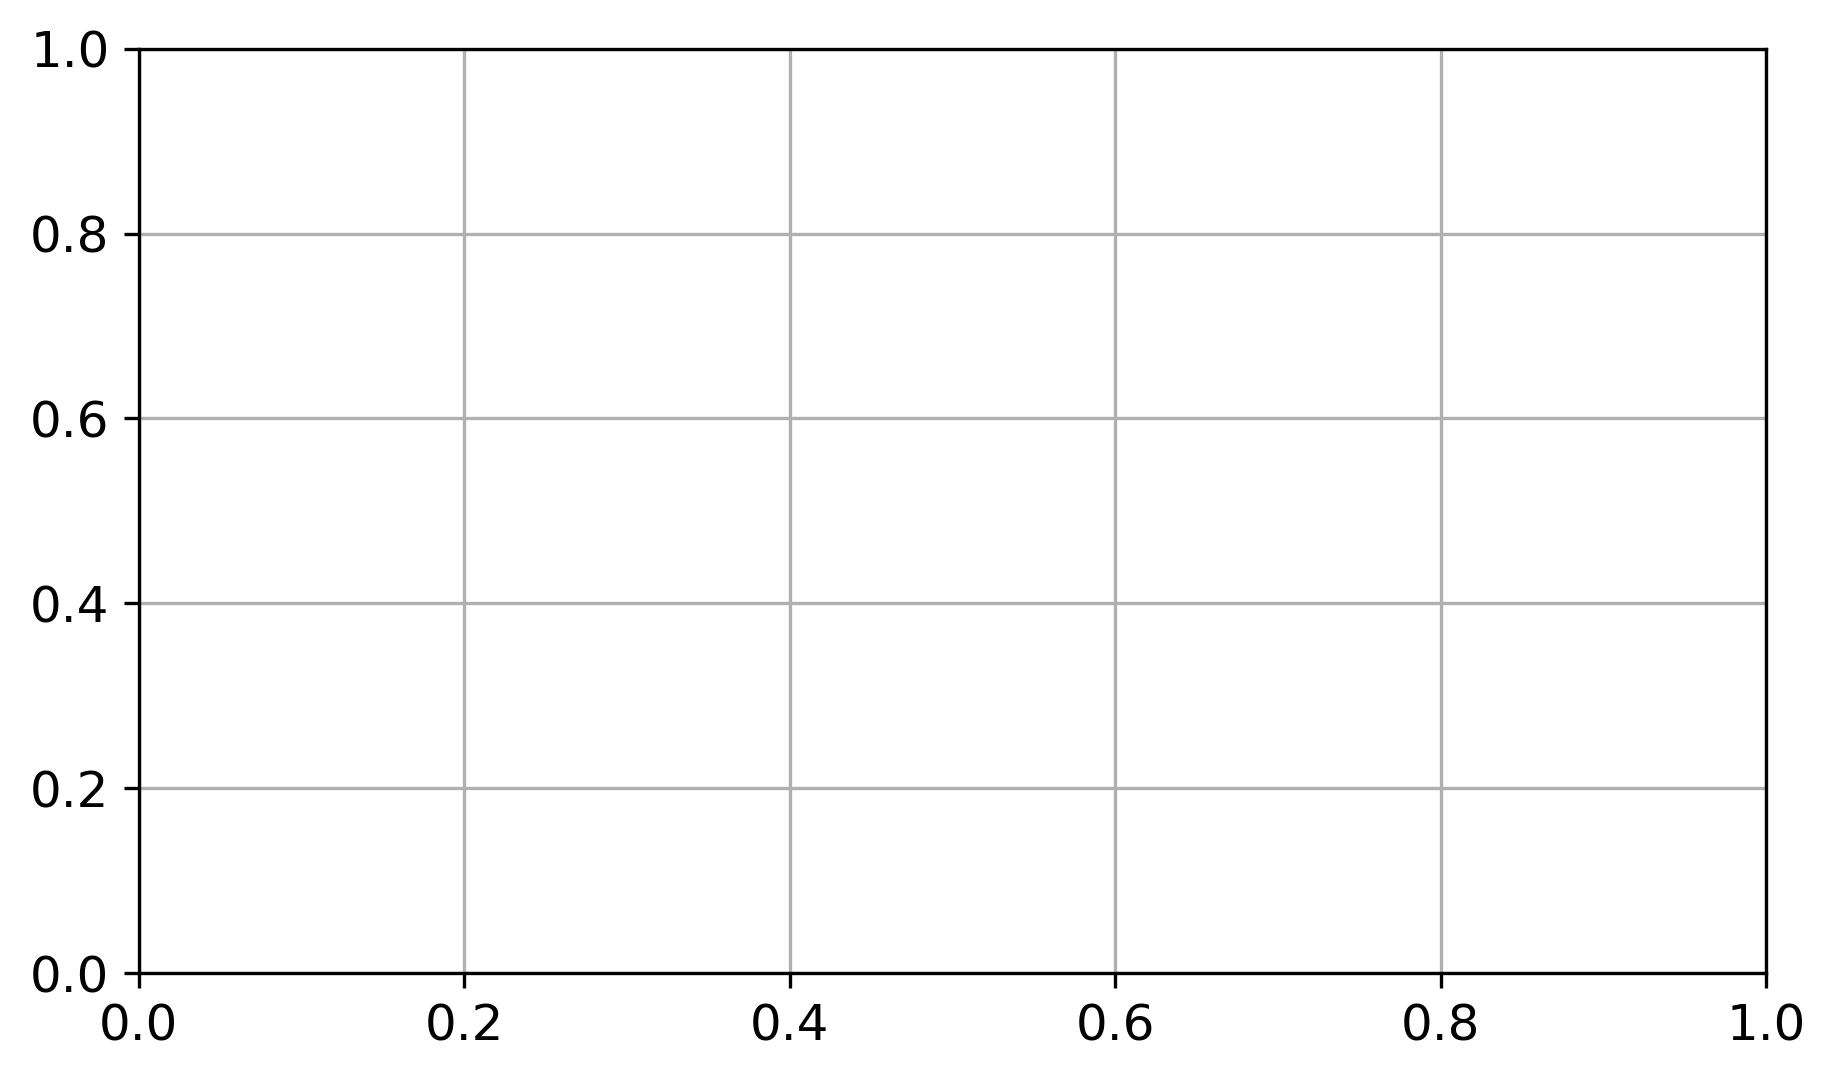

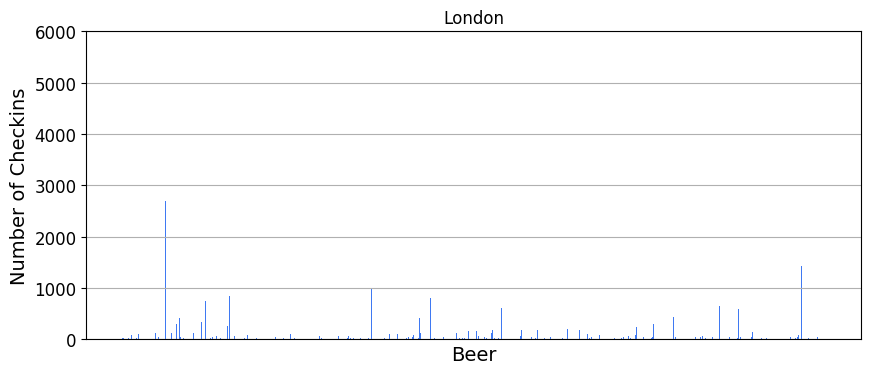

In [56]:
london_beer_counts = city2beers['london']

fig = plt.figure(figsize=(10, 4))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(range(len(london_beer_counts.values())), london_beer_counts.values(), alpha=1, color='#3f79f2', align='center')
plt.xticks([])
plt.ylabel('Number of Checkins', fontsize=14)
plt.xlabel('Beer', fontsize=14)
plt.title('London')
plt.autoscale()
plt.ylim((0,6000))
plt.show()

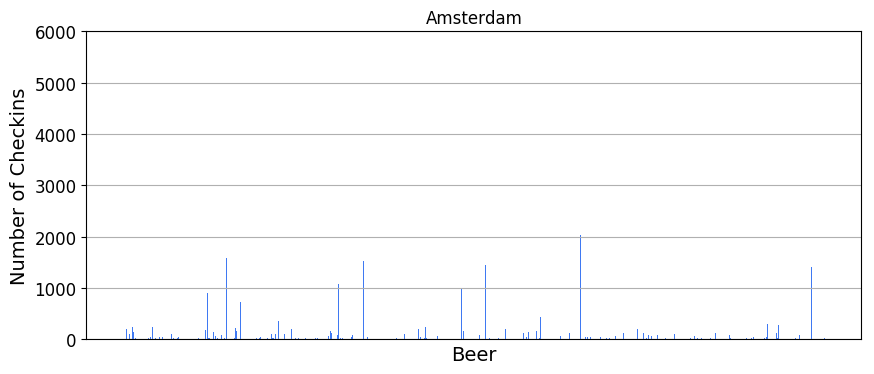

In [57]:
ams_beer_counts = city2beers['amsterdam']

fig = plt.figure(figsize=(10, 4))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(range(len(ams_beer_counts.values())), ams_beer_counts.values(), alpha=1, color='#3f79f2', align='center')
plt.xticks([])

plt.ylabel('Number of Checkins', fontsize=14)
plt.xlabel('Beer', fontsize=14)
plt.title('Amsterdam')
plt.autoscale()
plt.ylim(0,6000)
plt.show()

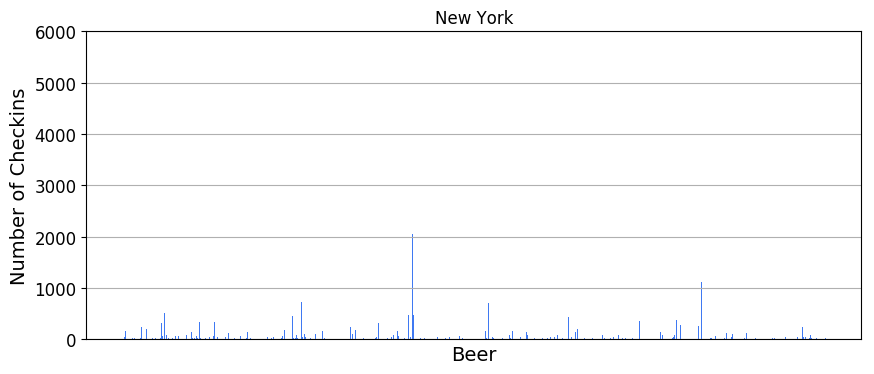

In [58]:
nyc_beer_counts = city2beers['newyork']

fig = plt.figure(figsize=(10, 4))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(range(len(nyc_beer_counts.values())), nyc_beer_counts.values(), alpha=1, color='#3f79f2', align='center')
plt.xticks([])

plt.ylabel('Number of Checkins', fontsize=14)
plt.xlabel('Beer', fontsize=14)
plt.title('New York')
plt.autoscale()
plt.ylim(0,6000)
plt.show()

In [62]:
london_beer_counts = city2beers['london']
topten = london_beer_counts.most_common(10)
for i, b_count in enumerate(topten):
    beer = bid2beer[b_count[0]]
    beer_name = beer['beer_name']
    print(beer_name, b_count[1])

London Pale Ale 14694
Punk IPA 14295
London Pride 13269
Guinness Draught 11704
Camden Pale Ale 10596
Gamma Ray 10241
Camden Hells 9520
Doom Bar 9038
Neck Oil 8714
Peroni Nastro Azzurro 7829


In [63]:
newyork_beer_counts = city2beers['newyork']
topten = newyork_beer_counts.most_common(10)
for i, b_count in enumerate(topten):
    beer = bid2beer[b_count[0]]
    beer_name = beer['beer_name']
    print(beer_name, b_count[1])

Brooklyn Lager 21286
Goose IPA 17551
Guinness Draught 15131
IPA 12639
Toasted Lager 10367
Bronx American Pale Ale 10274
Bud Light 10122
Mermaid Pilsner 10032
All Day IPA 9873
Traditional Lager 9611


In [64]:
ams_beer_counts = city2beers['amsterdam']
topten = ams_beer_counts.most_common(10)
for i, b_count in enumerate(topten):
    beer = bid2beer[b_count[0]]
    beer_name = beer['beer_name']
    print(beer_name, b_count[1])

Heineken 39207
Pilsener 11549
La Chouffe 11469
Zatte 10844
Amstel 10488
Jupiler 10243
IJwit 9673
Premium Pilsner / Premium Lager 9554
IPA 9536
Affligem Blond 9427


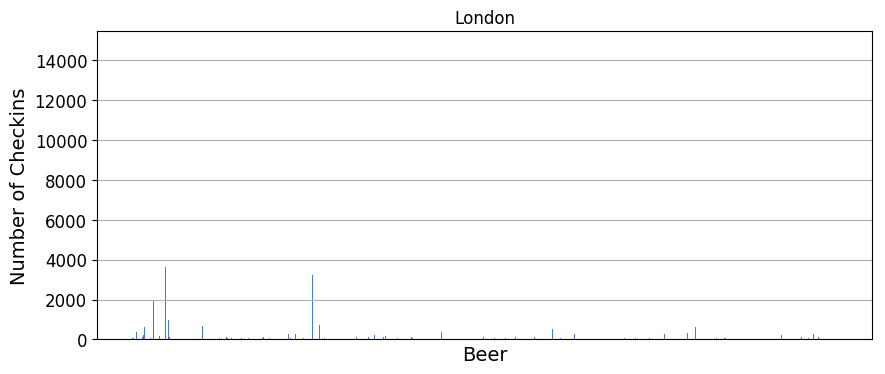

In [65]:
london_beer_counts = city2beers['london']

fig = plt.figure(figsize=(10, 4))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(range(len(london_beer_counts.values())), london_beer_counts.values(), alpha=1, color='#3f79f2', align='center')
plt.xticks([])
plt.ylabel('Number of Checkins', fontsize=14)
plt.xlabel('Beer', fontsize=14)
plt.title('London')
plt.autoscale()
plt.show()

In [66]:
top_thirty = global_unique_beer_count.most_common(30)
for i, b_count in enumerate(top_thirty):
        beer = bid2beer[b_count[0]]
        beer_name = beer['beer_name']
        beer_abv = beer['beer_abv']
        brewery = beer2brewery[beer['bid']]
        brewery = bid2brewery[brewery]
        brewery_name = brewery['brewery_name']
        brewery_country = brewery['country_name']
        brewery_state = brewery['location']['brewery_state']
        print("%d (%d): %s - %s (%.2f%%) - %s (%s)" % (i+1, b_count[1], brewery_name, beer_name, beer_abv, brewery_country, brewery_state))

1 (89928): Guinness - Guinness Draught (4.30%) - Ireland ()
2 (60975): Heineken - Heineken (5.00%) - Netherlands (Zuid Holland)
3 (56768): Lagunitas Brewing Company - IPA (6.20%) - United States (CA)
4 (54484): Goose Island Beer Co. - Goose IPA (5.90%) - United States (IL)
5 (46538): Revolution Brewing Company - Anti-Hero IPA (6.50%) - United States (IL)
6 (36783): Anheuser-Busch - Bud Light (4.20%) - United States (MO)
7 (31236): 3 Floyds Brewing Company - Zombie Dust (6.20%) - United States (IN)
8 (31162): Half Acre Beer Company - Daisy Cutter Pale Ale (5.20%) - United States (IL)
9 (30876): Brooklyn Brewery - Brooklyn Lager (5.20%) - United States (NY)
10 (30342): Stella Artois - Stella Artois (5.00%) - Belgium (Vlaams-Brabant)
11 (30223): Goose Island Beer Co. - Green Line Pale Ale (5.40%) - United States (IL)
12 (29315): Coors Brewing Company - Coors Light (4.20%) - United States (CO)
13 (29042): Boston Beer Company (Samuel Adams) - Samuel Adams Boston Lager (4.90%) - United State

In [67]:
top_thirty = eu_unique_beer_count.most_common(30)
for i, b_count in enumerate(top_thirty):
        beer = bid2beer[b_count[0]]
        beer_name = beer['beer_name']
        beer_abv = beer['beer_abv']
        brewery = beer2brewery[beer['bid']]
        brewery = bid2brewery[brewery]
        brewery_name = brewery['brewery_name']
        brewery_country = brewery['country_name']
        brewery_state = brewery['location']['brewery_state']
        print("%d (%d): %s - %s (%.2f%%) - %s (%s)" % (i+1, b_count[1], brewery_name, beer_name, beer_abv, brewery_country, brewery_state))

1 (50171): Heineken - Heineken (5.00%) - Netherlands (Zuid Holland)
2 (45039): Guinness - Guinness Draught (4.30%) - Ireland ()
3 (22451): BrewDog - Punk IPA (5.60%) - Scotland (Aberdeenshire, AB41 8BX)
4 (14940): Meantime Brewing Company - London Pale Ale (4.30%) - England (Greater London, SE10 0AR)
5 (14763): Grupo Damm - Estrella Damm (5.40%) - Spain (Cataluña)
6 (14434): Amstel Bier - Amstel (5.00%) - Netherlands (Zuid Holland)
7 (14113): Fuller, Smith & Turner  - London Pride (4.10%) - England ()
8 (13906): Brasserie d'Achouffe - La Chouffe (8.00%) - Belgium (Luxembourg)
9 (13184): Affligem Brouwerij - Affligem Blond (6.80%) - Belgium (Vlaams-Brabant)
10 (12149): Guinness - Hop House 13 Lager (4.10%) - Ireland ()
11 (11910): Birra Peroni - Peroni Nastro Azzurro (5.10%) - Italy (RM)
12 (11605): Hertog Jan - Pilsener (5.10%) - Netherlands (Limburg)
13 (11344): Carlsberg Group - Carlsberg (5.00%) - Denmark ()
14 (11315): Beavertown - Gamma Ray (5.40%) - England (London, N17 9QP)
15 (

In [68]:
top_thirty = us_unique_beer_count.most_common(30)
for i, b_count in enumerate(top_thirty):
        beer = bid2beer[b_count[0]]
        beer_name = beer['beer_name']
        beer_abv = beer['beer_abv']
        brewery = beer2brewery[beer['bid']]
        brewery = bid2brewery[brewery]
        brewery_name = brewery['brewery_name']
        brewery_country = brewery['country_name']
        brewery_state = brewery['location']['brewery_state']
        print("%d (%d): %s - %s (%.2f%%) - %s (%s)" % (i+1, b_count[1], brewery_name, beer_name, beer_abv, brewery_country, brewery_state))

1 (48192): Lagunitas Brewing Company - IPA (6.20%) - United States (CA)
2 (48153): Goose Island Beer Co. - Goose IPA (5.90%) - United States (IL)
3 (46521): Revolution Brewing Company - Anti-Hero IPA (6.50%) - United States (IL)
4 (44889): Guinness - Guinness Draught (4.30%) - Ireland ()
5 (36284): Anheuser-Busch - Bud Light (4.20%) - United States (MO)
6 (31027): Half Acre Beer Company - Daisy Cutter Pale Ale (5.20%) - United States (IL)
7 (30827): 3 Floyds Brewing Company - Zombie Dust (6.20%) - United States (IN)
8 (30091): Goose Island Beer Co. - Green Line Pale Ale (5.40%) - United States (IL)
9 (27893): Harpoon Brewery - Harpoon IPA (5.90%) - United States (MA)
10 (27467): Coors Brewing Company - Coors Light (4.20%) - United States (CO)
11 (26433): Boston Beer Company (Samuel Adams) - Samuel Adams Boston Lager (4.90%) - United States (MA)
12 (24525): Blue Moon Brewing Company - Belgian White (5.40%) - United States (CO)
13 (23763): Stella Artois - Stella Artois (5.00%) - Belgium 

In [70]:
for city, beer_counts in city2beers.items():
    print(city)
    top_five = beer_counts.most_common()[0:5]
    for b_count in top_five:
        beer = bid2beer[b_count[0]]
        beer_name = beer['beer_name']
        beer_abv = beer['beer_abv']
        brewery = beer2brewery[beer['bid']]
        brewery = bid2brewery[brewery]
        brewery_name = brewery['brewery_name']
        brewery_country = brewery['country_name']
        brewery_state = brewery['location']['brewery_state']
        print("%d: %s - %s (%.2f%%) - %s (%s)" % (b_count[1], brewery_name, beer_name, beer_abv, brewery_country, brewery_state))
    print("")

copenhagen
5520: Carlsberg Group - Tuborg Classic (4.60%) - Denmark ()
4967: Carlsberg Group - Carlsberg (5.00%) - Denmark ()
3900: Carlsberg Group - Brewmasters Collection India Pale Ale (5.20%) - Denmark ()
3430: Carlsberg Group - Tuborg Grøn (4.60%) - Denmark ()
2270: Jacobsen - Brown Ale (6.00%) - Denmark (799 København V)

amsterdam
39207: Heineken - Heineken (5.00%) - Netherlands (Zuid Holland)
11549: Hertog Jan - Pilsener (5.10%) - Netherlands (Limburg)
11469: Brasserie d'Achouffe - La Chouffe (8.00%) - Belgium (Luxembourg)
10844: Brouwerij 't IJ - Zatte (8.00%) - Netherlands (Noord-Holland)
10488: Amstel Bier - Amstel (5.00%) - Netherlands (Zuid Holland)

london
14694: Meantime Brewing Company - London Pale Ale (4.30%) - England (Greater London, SE10 0AR)
14295: BrewDog - Punk IPA (5.60%) - Scotland (Aberdeenshire, AB41 8BX)
13269: Fuller, Smith & Turner  - London Pride (4.10%) - England ()
11704: Guinness - Guinness Draught (4.30%) - Ireland ()
10596: Camden Town Brewery - Cam

{'copenhagen': 0          9.0
1          5.0
2          5.9
3          0.0
4          3.8
5          6.0
6          7.4
7          8.0
8         12.0
9          6.6
10         8.5
11        11.0
12         6.2
13         5.0
14         6.0
15         6.2
16         4.6
17         4.6
18         4.7
19         6.0
20         7.5
21         4.6
22        10.4
23         6.5
24        10.5
25         6.2
26         2.8
27         6.5
28         5.8
29         6.2
          ... 
692294     0.0
692295     0.3
692296     7.0
692297     5.0
692298     5.3
692299     4.8
692300     4.6
692301     6.5
692302     5.5
692303     7.0
692304     4.5
692305     0.0
692306    12.0
692307     8.5
692308     3.5
692309     6.4
692310     6.0
692311     9.0
692312    12.0
692313     6.0
692314     6.5
692315     5.2
692316     6.0
692317     5.2
692318     5.0
692319    10.0
692320     5.3
692321     5.9
692322     5.0
692323     5.5
Name: copenhagen, Length: 692324, dtype: float64, 'boston': 0         

         amsterdam  barcelona  boston  chicago  copenhagen  denver  dublin  \
0              3.8        6.0     7.0    11.10         9.0     5.0     4.5   
1              6.6        5.5     4.1     8.50         5.0     7.0     5.4   
2              5.5        4.7     8.7     5.30         5.9     4.0     5.0   
3              5.0        7.3     4.6     4.74         0.0     8.4     4.5   
4              5.0        6.2     5.9     6.50         3.8     6.5     4.0   
5              6.0        6.0     5.7     6.90         6.0     5.4     4.5   
6              6.0        5.2     7.0     8.40         7.4     6.5     4.1   
7              7.0        5.5     5.5     5.50         8.0     7.5     5.7   
8              7.0        8.0     5.6     5.50        12.0     5.5     4.3   
9              5.0        6.5     5.6     6.66         6.6    12.5     6.1   
10             5.0        8.7     7.5     9.50         8.5     3.8     4.3   
11             8.0        5.0     4.8    14.10        11.0     7

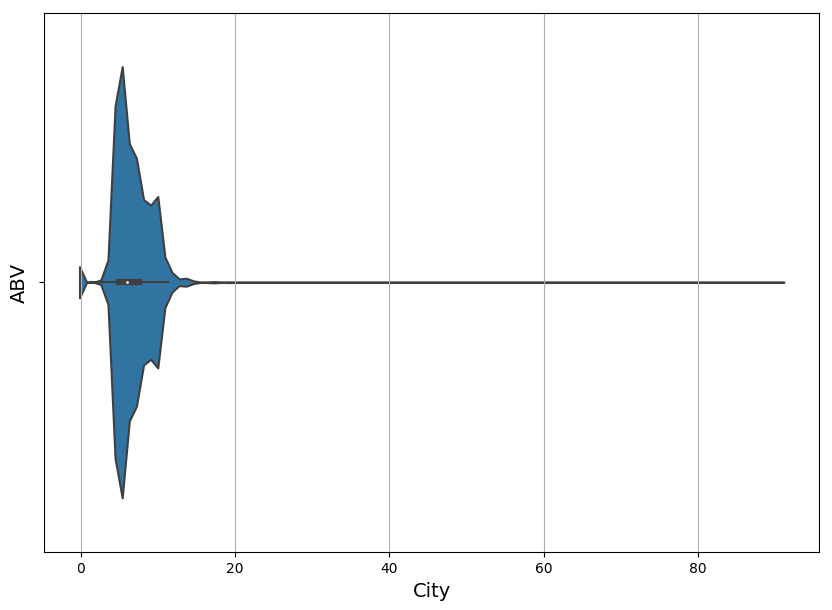

In [87]:
fig = plt.figure(figsize=(10, 7))

data = {}
labels = []

for city in sorted_city_names:
    data[city] = pandas.Series(beer_abvs[city], name=city)
    labels.append(city)

print(data)
df = pandas.DataFrame(data)
print(df)

    
sns.violinplot(df.T)
plt.xticks(list(range(1,13)), ['%s - %s' % (c, cities2code[c]) for c in labels], rotation='vertical')

plt.ylabel('ABV', fontsize=14)
plt.xlabel('City', fontsize=14)
plt.show()


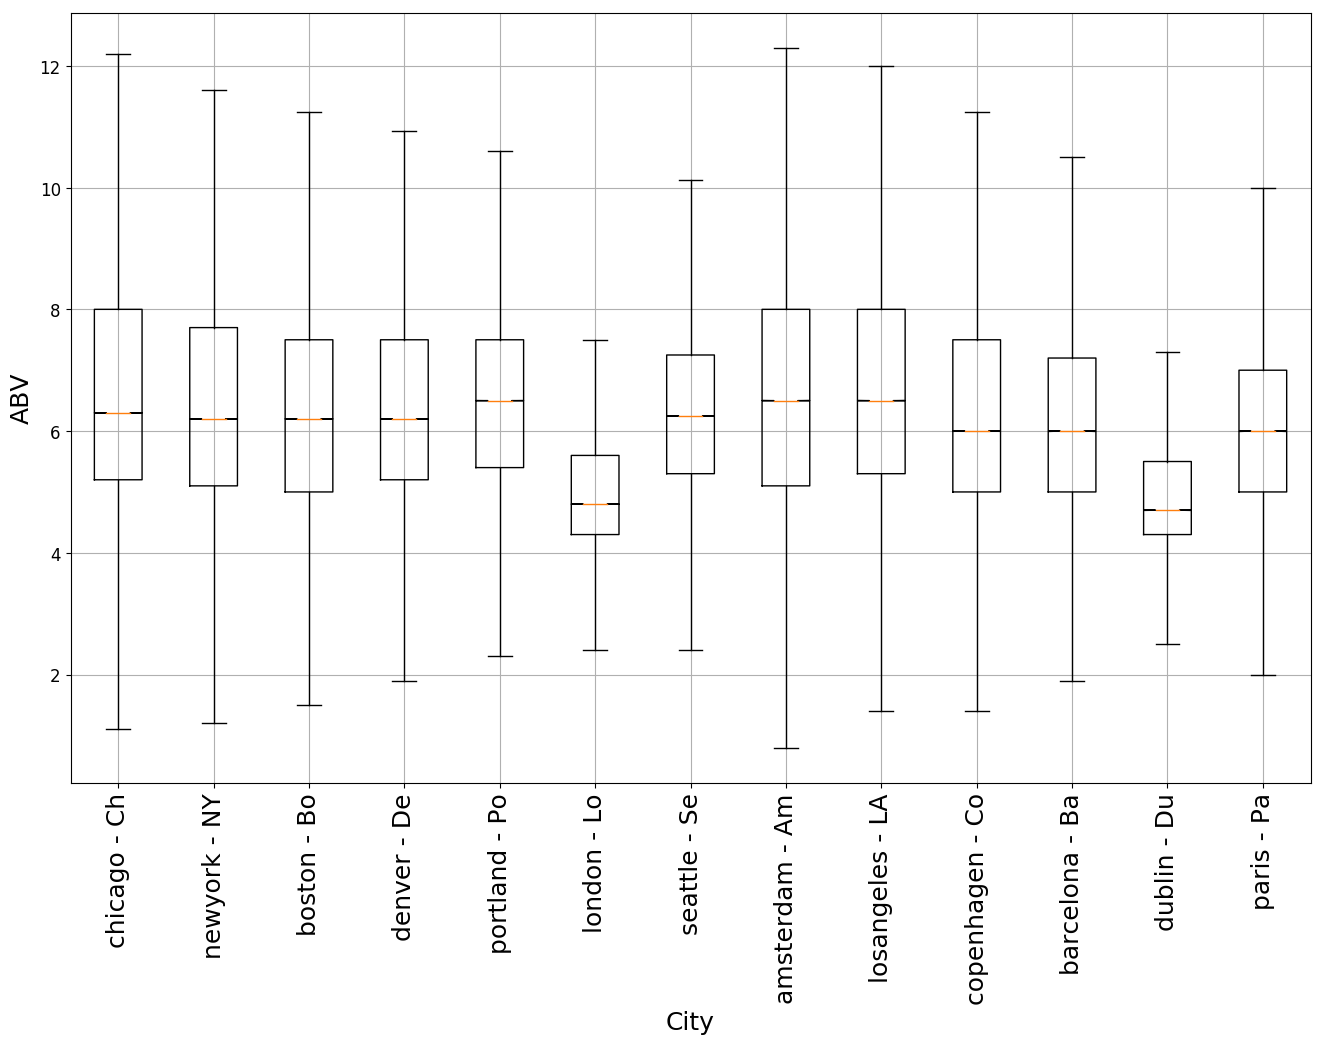

In [111]:
fig = plt.figure(figsize=(16, 10))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)
data = []
labels = []

for city in sorted_city_names:
    data.append(beer_abvs[city])
    labels.append(city)
    
plt.boxplot(data, notch=True, showfliers=False, manage_xticks=True)
plt.xticks(list(range(1,14)), ['%s - %s' % (c, cities2code[c]) for c in labels], rotation='vertical', fontsize=18)

plt.ylabel('ABV', fontsize=18)
plt.xlabel('City', fontsize=18)
plt.show()
fig.savefig('plots/abv_per_city_box.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/abv_per_city_box.png', bbox_inches='tight', pad_inches=0.5)

In [94]:
data = {}
labels = []

for city in sorted_city_names:
    data[city] = pandas.Series(beer_abvs[city], name=city)

df = pandas.DataFrame(data)
print(df)

df_m = df.melt(value_vars=sorted_city_names, var_name='city', value_name='abv')
print(df_m)

         amsterdam  barcelona  boston  chicago  copenhagen  denver  dublin  \
0              3.8        6.0     7.0    11.10         9.0     5.0     4.5   
1              6.6        5.5     4.1     8.50         5.0     7.0     5.4   
2              5.5        4.7     8.7     5.30         5.9     4.0     5.0   
3              5.0        7.3     4.6     4.74         0.0     8.4     4.5   
4              5.0        6.2     5.9     6.50         3.8     6.5     4.0   
5              6.0        6.0     5.7     6.90         6.0     5.4     4.5   
6              6.0        5.2     7.0     8.40         7.4     6.5     4.1   
7              7.0        5.5     5.5     5.50         8.0     7.5     5.7   
8              7.0        8.0     5.6     5.50        12.0     5.5     4.3   
9              5.0        6.5     5.6     6.66         6.6    12.5     6.1   
10             5.0        8.7     7.5     9.50         8.5     3.8     4.3   
11             8.0        5.0     4.8    14.10        11.0     7

             city    abv
0         chicago  11.10
1         chicago   8.50
2         chicago   5.30
3         chicago   4.74
4         chicago   6.50
5         chicago   6.90
6         chicago   8.40
7         chicago   5.50
8         chicago   5.50
9         chicago   6.66
10        chicago   9.50
11        chicago  14.10
12        chicago   5.00
13        chicago   9.40
14        chicago   6.50
15        chicago   9.70
16        chicago   5.80
17        chicago   9.32
18        chicago   6.50
19        chicago  11.40
20        chicago   6.20
21        chicago  11.10
22        chicago   7.00
23        chicago   6.50
24        chicago   5.90
25        chicago   4.80
26        chicago   6.00
27        chicago   5.40
28        chicago   9.00
29        chicago   0.00
...           ...    ...
45024053    paris    NaN
45024054    paris    NaN
45024055    paris    NaN
45024056    paris    NaN
45024057    paris    NaN
45024058    paris    NaN
45024059    paris    NaN
45024060    paris    NaN


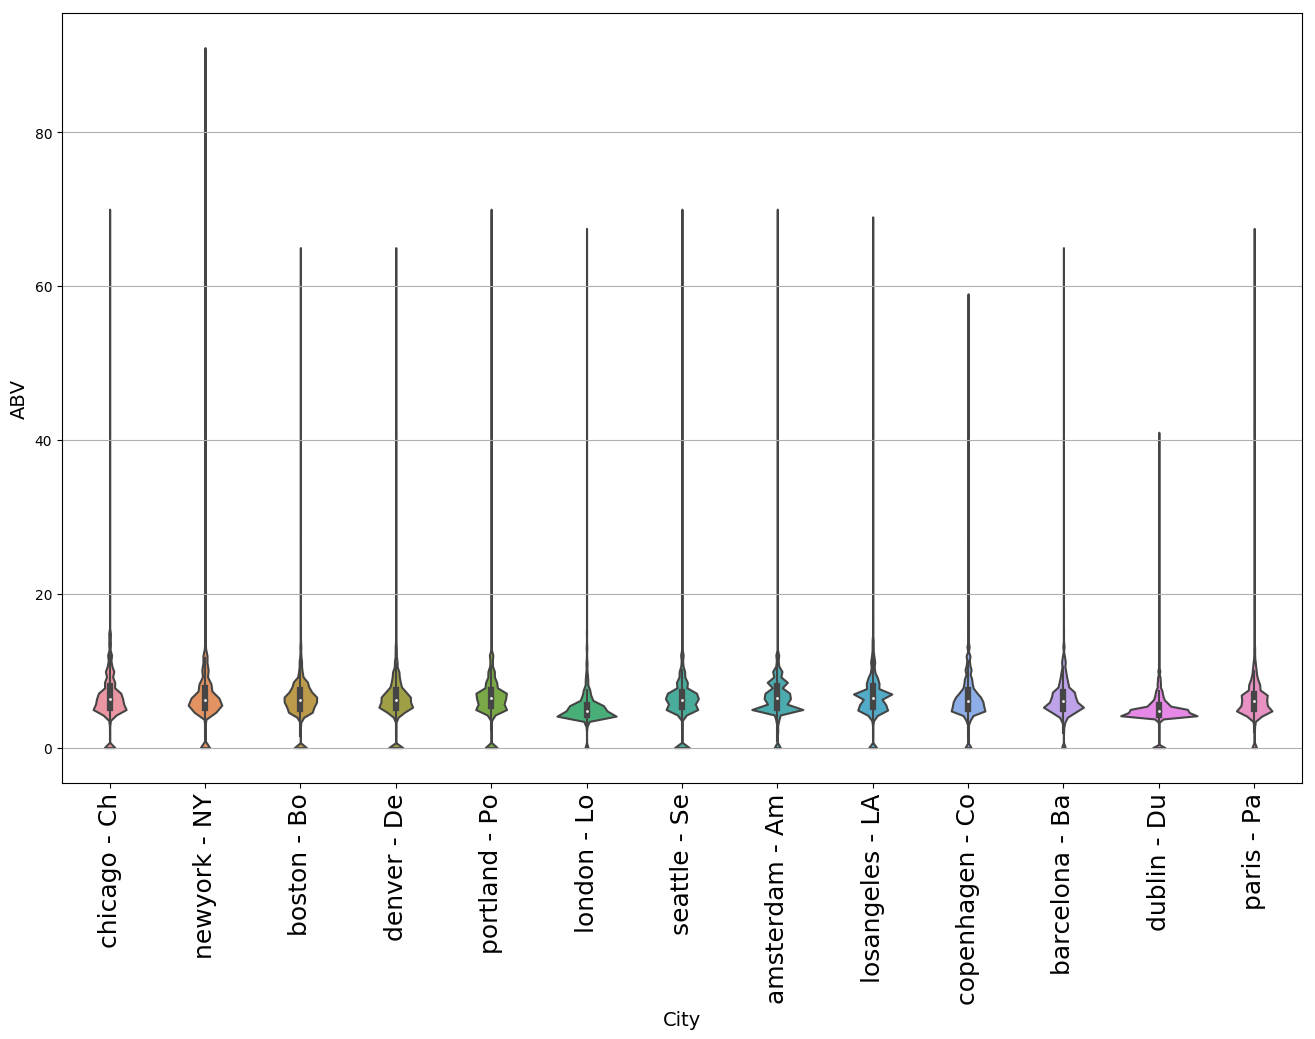

In [114]:
fig = plt.figure(figsize=(16, 10))
sns.violinplot(x='city', y='abv', data=df_m, cut=0)
plt.xticks(list(range(0,13)), ['%s - %s' % (c, cities2code[c]) for c in sorted_city_names], rotation='vertical', fontsize=18)
plt.ylabel('ABV', fontsize=14)
plt.xlabel('City', fontsize=14)
plt.show()

fig.savefig('plots/abv_per_city.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/abv_per_city.png', bbox_inches='tight', pad_inches=0.5)

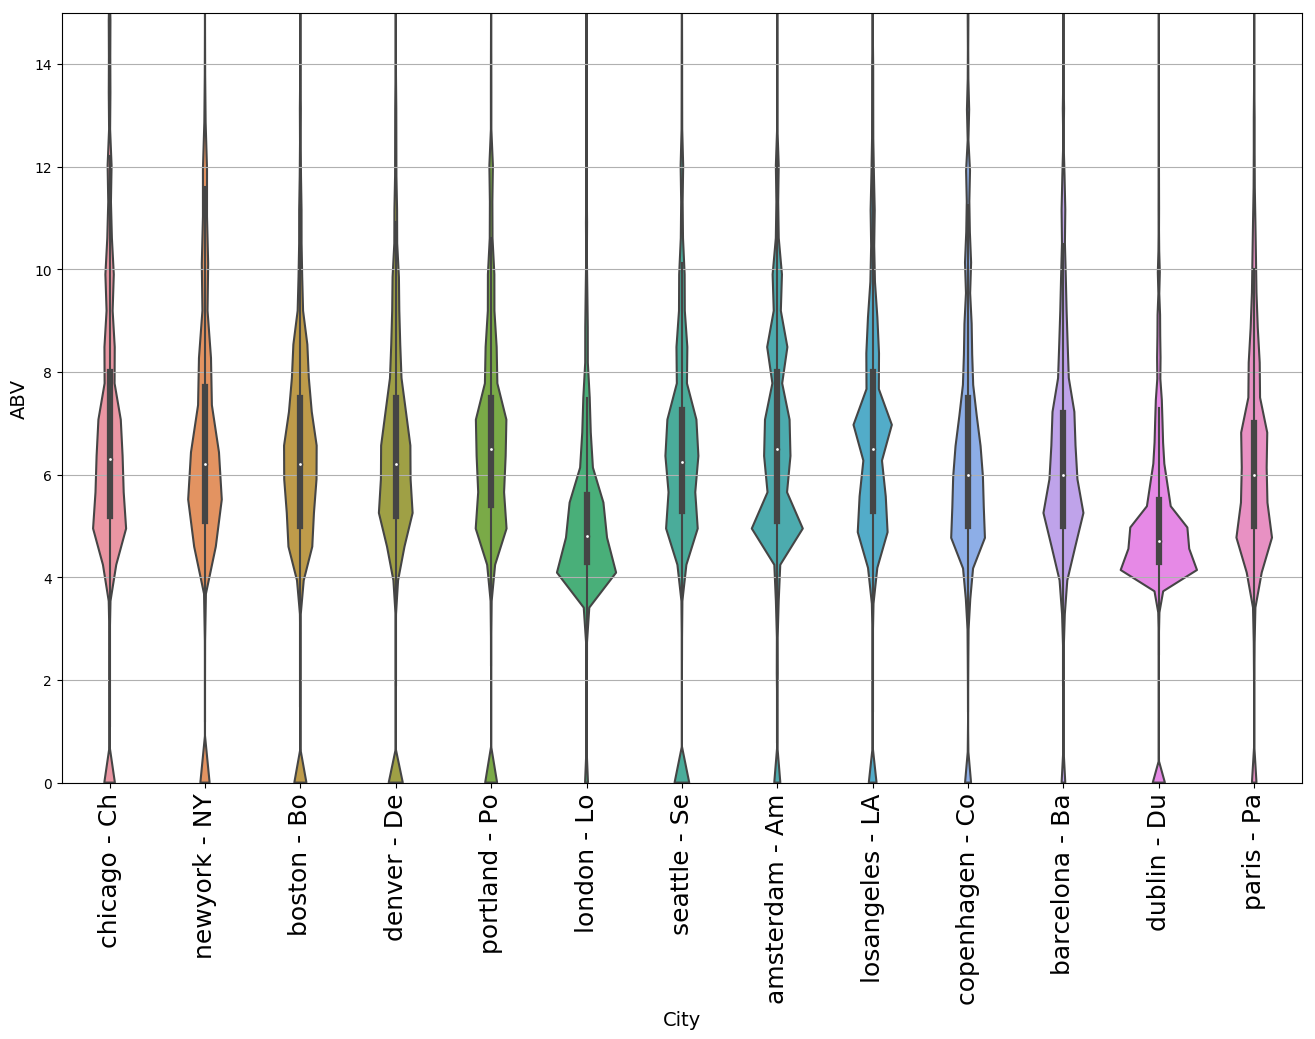

In [113]:
fig = plt.figure(figsize=(16, 10))

sns.violinplot(x='city', y='abv', data=df_m, cut=0)
plt.xticks(list(range(0,13)), ['%s - %s' % (c, cities2code[c]) for c in sorted_city_names], rotation='vertical', fontsize=18)
plt.ylim([0, 15])
plt.ylabel('ABV', fontsize=14)
plt.xlabel('City', fontsize=14)
plt.show()

fig.savefig('plots/abv_per_city_trimmed.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/abv_per_city_trimmed.png', bbox_inches='tight', pad_inches=0.5)

In [108]:
print(df_m.describe())
print(df.describe())

                abv
count  2.087068e+07
mean   6.439025e+00
std    2.355061e+00
min    0.000000e+00
25%    5.000000e+00
50%    6.000000e+00
75%    7.500000e+00
max    9.100000e+01
          amsterdam      barcelona        boston       chicago     copenhagen  \
count  1.646201e+06  266232.000000  2.217508e+06  3.463391e+06  692324.000000   
mean   6.646353e+00       6.381729  6.392741e+00  6.796513e+00       6.476984   
std    2.219079e+00       2.179169  2.237962e+00  2.609292e+00       2.530380   
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00       0.000000   
25%    5.100000e+00       5.000000  5.000000e+00  5.200000e+00       5.000000   
50%    6.500000e+00       6.000000  6.200000e+00  6.300000e+00       6.000000   
75%    8.000000e+00       7.200000  7.500000e+00  8.000000e+00       7.500000   
max    7.000000e+01      65.000000  6.500000e+01  7.000000e+01      59.000000   

             denver         dublin        london    losangeles       newyork  \
count  1.9

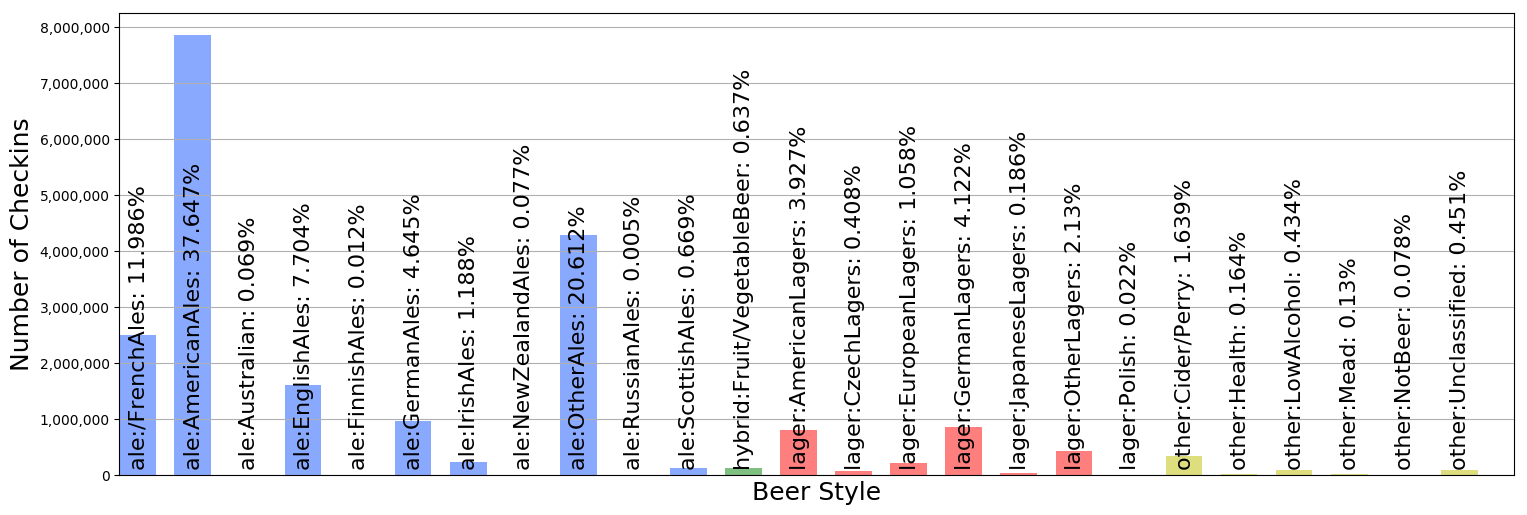

In [120]:
y = [j for (i,j) in sorted(zip(global_beer_style_counts.keys(), global_beer_style_counts.values()))]
xlabels = sorted(global_beer_style_counts.keys())

colours = []
for label in xlabels:
    if 'lager' in label:
        colours.append('r')
    elif 'ale' in label:
        colours.append('#1554ff')
    elif 'hybrid' in label:
        colours.append('g')
    else:
        colours.append('y')

bar_width = 2
x = np.arange(0,len(y)*3,3)

fig = plt.figure(figsize=[18, 6])
fig.patch.set_facecolor('white')

plt.bar(x,y,width=bar_width,linewidth=1,alpha=.5,color=colours)
#plt.yscale('log')
plt.ylabel('Number of Checkins', fontsize=18)
plt.xlim([-1,75])
plt.xlabel('Beer Style', fontsize=18)

ax = plt.gca()
rects = ax.patches
for i,(rect, label) in enumerate(zip(rects, xlabels)):
    value = float("{0:.3f}".format(100*y[i]/float(sum(y))))
    elabel = label + ': ' + str(value) + '%'
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2 + .6, 100000, elabel, ha='right', va='bottom',rotation='vertical',fontsize='16')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.axes.get_xaxis().set_ticks([])
plt.show()
fig.savefig('plots/global_beer_styles.pdf', bbox_inches='tight', pad_inches=0.5)
fig.savefig('plots/global_beer_styles.png', bbox_inches='tight', pad_inches=0.5)

In [134]:
for city in tqdm_notebook(CITIES):

    y = [j for (i,j) in sorted(zip(beer_style_counts[city].keys(), beer_style_counts[city].values()))]
    xlabels = sorted(beer_style_counts[city].keys())

    colours = []
    for label in xlabels:
        if 'lager' in label:
            colours.append('r')
        elif 'ale' in label:
            colours.append('#1554ff')
        elif 'hybrid' in label:
            colours.append('g')
        else:
            colours.append('y')

    bar_width = 2
    x = np.arange(0,len(y)*3,3)

    offset = max(beer_style_counts[city].values())/60

    fig = plt.figure(figsize=[18, 6])
    fig.patch.set_facecolor('white')

    plt.bar(x,y,width=bar_width,linewidth=1,alpha=.5,color=colours)
    #plt.yscale('log')
    plt.ylabel('Number of Checkins', fontsize=18)
    plt.xlim([-1,75])
    plt.xlabel('Beer Style', fontsize=18)
    plt.title(city.title(), fontsize=20)

    ax = plt.gca()
    rects = ax.patches
    for i,(rect, label) in enumerate(zip(rects, xlabels)):
        value = float("{0:.3f}".format(100*y[i]/float(sum(y))))
        elabel = label + ': ' + str(value) + '%'
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2 + .6, offset, elabel, ha='right', va='bottom',rotation='vertical',fontsize='16')
    ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.axes.get_xaxis().set_ticks([])
    fig.savefig('plots/beer_styles_%s.pdf' % city, bbox_inches='tight', pad_inches=0.5)
    fig.savefig('plots/beer_styles_%s.png' % city, bbox_inches='tight', pad_inches=0.5)
    plt.close(fig)

A Jupyter Widget

In [136]:
# already executed above

beer2rating = Counter()
beer2checkins = Counter()

for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        beer = c['beer']
        rating = float(c['rating'])
        if rating:
            beer2rating[beer] += rating
            beer2checkins[beer] += 1
        
# get average rating per checkin
for beer in beer2rating.keys():
    beer2rating[beer] /= beer2checkins[beer]

A Jupyter Widget

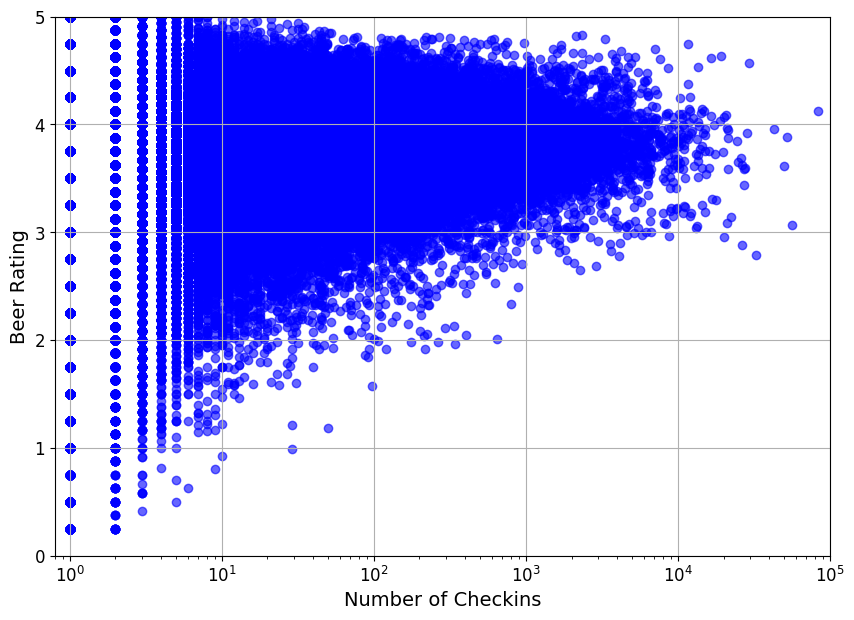

In [137]:
x = list(beer2checkins.values())
y = list(beer2rating.values())

fig = plt.figure(figsize=(10, 7))

fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.scatter(x, y, c='b', alpha=.6)

plt.xscale('log')
plt.xlim([0.8,1.2*max(x)])
plt.ylim(0,5)
plt.ylabel('Beer Rating', fontsize=14)
plt.xlabel('Number of Checkins', fontsize=14)
plt.show()

In [139]:
#already executed above
eu = []
us = []
for city in tqdm_notebook(CITIES):
    checkins = checkin_data[city]
    for c in checkins:
        rating_score = float(c['rating'])
        if rating_score:
            if city in EU_CITIES:
                eu.append(rating_score)
            else:
                us.append(rating_score)

eu = pandas.Series(eu)
us = pandas.Series(us)

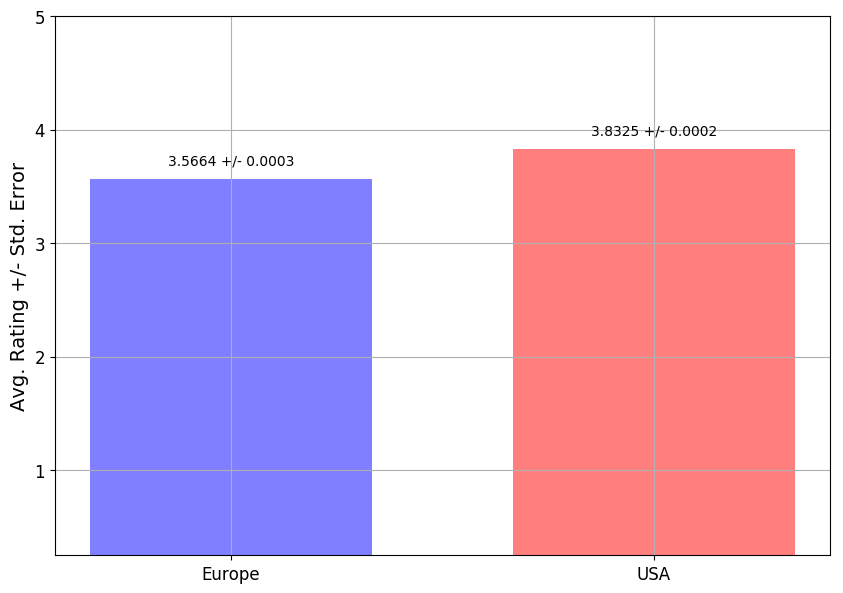

In [142]:
y = [eu.mean(),us.mean()]
standard_error = [eu.sem(),us.sem()]

xlabels = ['Europe','USA']
bar_width = 2
x = np.arange(0, len(y) * 3, 3)


fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.bar(x, y, width=bar_width, color=['b','r'], alpha=0.5)
plt.xticks(x, xlabels,rotation='horizontal')
plt.ylabel('Avg. Rating +/- Std. Error', fontsize=14)
# plt.xlim([-2,6])
plt.ylim([.25,5])
ax = plt.gca()
rects = ax.patches

labels = [str(format(y[i],'.4f')) + " +/- " + str(format(standard_error[i],'.4f')) for i in range(len(y))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + .1, label, ha='center', va='bottom')

plt.show()

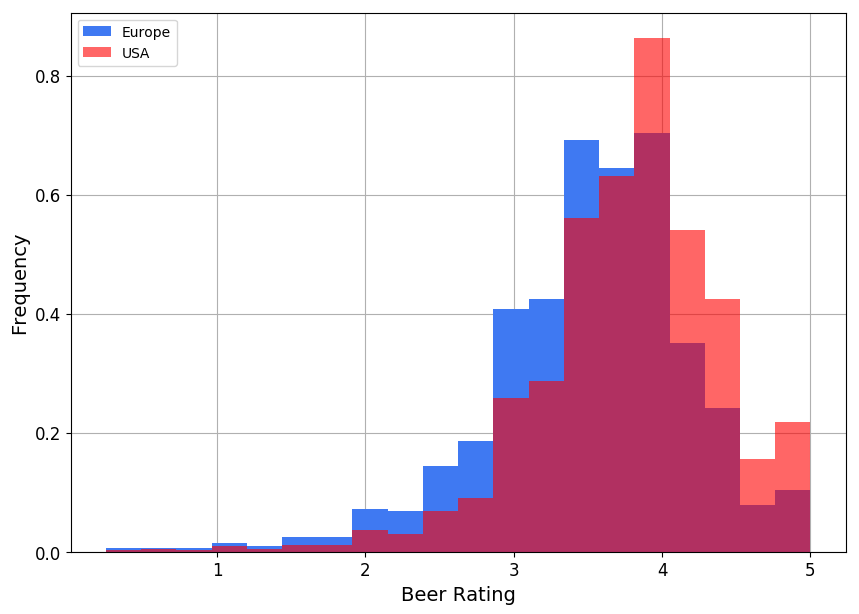

In [143]:
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.hist(eu, bins=20, alpha=1, label='Europe', normed=True, color='#3f79f2')
plt.hist(us, bins=20, alpha=0.6, label='USA', normed=True, color='r')

ax = plt.gca()
ax.set_axisbelow(True)

plt.xlabel('Beer Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper left')
plt.show()